# Autoencoder with Convolution & Deconvolution Example


<img src="images/DLItalia.001.jpg" alt="Drawing" style="width: 700px;"/>

<img src="images/DLItalia.002.jpg" alt="Drawing" style="width: 700px;"/>

![](images/001.JPEG)

# Task of the presentation

Build a 2 layers auto-encoder with TensorFlow to compress images to a lower latent space and then reconstruct them.

## Auto-Encoder Overview

Autoencoders are unsupervised neural networks that aim to copy their inputs to their outputs. They work by compressing the input into a **latent-space representation**, and then reconstructing the output from this representation. 

<img src="https://experimentationground.files.wordpress.com/2016/09/ps_nn_graphic_colors21.png?w=498&h=197" alt="ae" style="width: 800px;"/>

- The **latent vector** is the essence of the autoencoder;

- The encoder and the decoder could be composed by any kind of layers. We will se a CNN-autoencoder;

**Encoder:** This is the part of the network that compresses the input into a latent-space representation. It can be represented by an encoding function 

### $$h=f(x).$$

**Decoder**: This part aims to reconstruct the input from the latent space representation. It can be represented by a decoding function 

### $$r=g(h).$$


The autoencoder as a whole can thus be described by the function 

### $$g(f(x)) = r.$$ 

where $r$ is called *reconstruction*. By training the autoencoder to copy the input to the output ($r$ as close as the original input $x$), the latent representation $h$ will take on useful properties. For instance, if the dimension of $h$ is smaller than $x$ we can construct a representation of the input which is compressed. This forces the autoencoder to learn the most salient features of the training data (a sort of PCA).

References:
- [Gradient-based learning applied to document recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Proceedings of the IEEE, 86(11):2278-2324, November 1998.

## Applications of Auto-Encoders

- **Dimensional Reduction**;
- **Denoising**: the input is an image with some noise added. The loss function is setted to minimize the difference between the reconstructed image and the original noise-free image;
- **Seq2Seq**: Sequence to Sequence models (language translation, for instance) have an encoder-decoder structure.

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

## Deconvolutional Layer (transposed conv-layer)

A deconvolutional layer is just the transposed of its corresponding convolutional layer (E.g. if conv layer's shape is [height, width, numColors, numMaps], than the deconv layer will have the shape [height, width, numMaps, numColors])

one-to-many (deconv; feature to pixels) rather than many-to-one (conv; pixels to feature) association

### Math of Convolution

<img src="https://cdn-images-1.medium.com/max/800/1*NoXQbZqPnxSnjdAwo93XcQ.png" alt="ae" style="width: 600px;"/>

<img src="https://cdn-images-1.medium.com/max/800/1*ql2ZxrS_h8D7KHNCrGndug.png" alt="ae" style="width: 600px;"/>

### Math of Transposed Convolution

<img src="https://cdn-images-1.medium.com/max/800/1*JDAuBt3aS9mz3aQQ7JKYKA.png" alt="ae" style="width: 600px;"/>

## Tensorflow Auto-Encoder

### - Python 3.6

### - Tensorflow 1.9

In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import tensorflow.contrib.slim as slim

import math
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

/home/asr/tensorflow-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/asr/tensorflow-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/home/asr/machine-learning-lab/MNIST-data", one_hot=True)

Extracting /home/asr/machine-learning-lab/MNIST-data/train-images-idx3-ubyte.gz
Extracting /home/asr/machine-learning-lab/MNIST-data/train-labels-idx1-ubyte.gz
Extracting /home/asr/machine-learning-lab/MNIST-data/t10k-images-idx3-ubyte.gz
Extracting /home/asr/machine-learning-lab/MNIST-data/t10k-labels-idx1-ubyte.gz


### Parameters and Activation Function

We use a **leaky ReLU** which instead of clipping the negative values to zero, cuts them to a specific amount based on a hyperparameter alpha. This ensures that the network learns something even when the pixel value is below zero.

In [79]:
tf.reset_default_graph()

# Training Parameters
learning_rate = 0.01
num_steps = 1000
batch_size = 128
imsize = 28

# Noise Parameter
noise_variance = 0.2

display_step = 100
examples_to_show = 10

def lrelu(x,alpha=0.1):
    return tf.maximum(alpha*x,x)

# tf Graph input (only pictures)
X = tf.placeholder("float", [None, 28, 28, 1])
X_noisy = tf.placeholder("float", [None, 28, 28, 1])

#X = tf.placeholder("float", [None, 784])

## Autoencoder using Convolutional & Deconvolutional layers

In [80]:
# Building the encoder
# tf.nn.relu
def encoder(x):
    with tf.variable_scope('encoder'): 
        layer_1 = slim.conv2d(x, 3, [10,10], stride=2, padding='SAME', activation_fn=lrelu, scope='conv1')
        print(layer_1.name)
        print('1', layer_1.get_shape())
        layer_2 = slim.conv2d(layer_1, 3, [3,3], stride=2, padding='SAME', activation_fn=lrelu, scope='conv2')
        print('2', layer_2.get_shape())
        return layer_2


# Building the decoder
def decoder(x):
    with tf.variable_scope('decoder'): 
        layer_1 = slim.layers.conv2d_transpose(x, 3, [3,3], stride=2, padding='SAME', activation_fn=lrelu, scope='conv1')
        print('1', layer_1.get_shape())
        layer_2 = slim.layers.conv2d_transpose(layer_1, 1, [10,10], stride=2, padding='SAME', activation_fn=lrelu, scope='conv2')
        print('2', layer_2.get_shape())
    return layer_2

# Construct model
encoder_input = X_noisy
encoder_output = encoder(encoder_input)
decoder_output = decoder(encoder_output)


# Targets (Labels) are the input data.
y_target = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_target - decoder_output, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

encoder/conv1/Maximum:0
1 (?, 14, 14, 3)
2 (?, 7, 7, 3)
1 (?, 14, 14, 3)
2 (?, 28, 28, 1)


In [81]:
# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
plot_step = []
plot_loss = []
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    batch_x = batch_x 
    # Reshape the batch correctly
    batch_x = batch_x.reshape([-1, 28, 28, 1])
    batch_x_noisy = batch_x + np.random.normal(0, noise_variance, (batch_x.shape[0], batch_x.shape[1],batch_x.shape[2],batch_x.shape[3]))
    # Run optimization op (backprop) and cost op (to get loss value)
    _, l = sess.run([optimizer, loss], feed_dict={X: batch_x, X_noisy: batch_x_noisy})
    #_, l = sess.run([optimizer, loss], feed_dict={X: batch_x, X_noisy: batch_x})
    # Display logs per step
    if i % display_step == 0 or i == 1:
        plot_step.append(i)
        plot_loss.append(l)
        print('Step %i: Minibatch Loss: %f' % (i, l))

Step 1: Minibatch Loss: 0.108719
Step 100: Minibatch Loss: 0.060057
Step 200: Minibatch Loss: 0.019505
Step 300: Minibatch Loss: 0.021406
Step 400: Minibatch Loss: 0.014105
Step 500: Minibatch Loss: 0.015070
Step 600: Minibatch Loss: 0.013783
Step 700: Minibatch Loss: 0.012486
Step 800: Minibatch Loss: 0.011972
Step 900: Minibatch Loss: 0.011191
Step 1000: Minibatch Loss: 0.013671


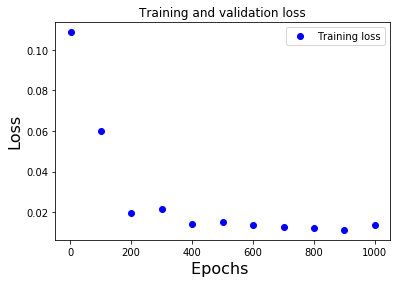

<Figure size 432x288 with 0 Axes>

In [83]:
plt.plot(plot_step, plot_loss, 'bo', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

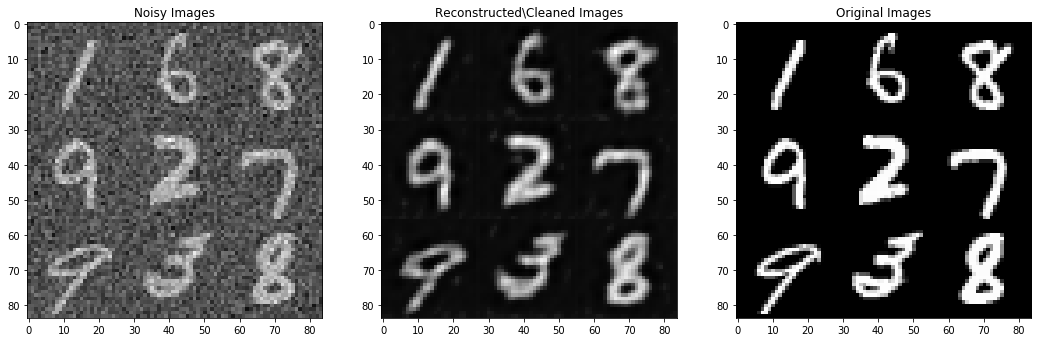

In [84]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 3
m = 3
canvas_noisy = np.empty((28 * n, 28 * m))
canvas_recon = np.empty((28 * n, 28 * m))
canvas_orig = np.empty((28 * n, 28 * m))
for i in range(n):
    # MNIST test set
    batch_x, _ = mnist.test.next_batch(n)
    batch_x = batch_x
    # Encode and decode the digit image
    batch_x = batch_x.reshape([n, 28, 28, 1])
    #batch_x_noisy = batch_x + 0.2*tf.random_normal(tf.shape(batch_x))
    batch_x_noisy = batch_x + np.random.normal(0, noise_variance, (batch_x.shape[0], batch_x.shape[1],batch_x.shape[2],batch_x.shape[3]))
    #g = sess.run(decoder_op, feed_dict={X: batch_x})
    results = sess.run(decoder_output, feed_dict={X: batch_x, X_noisy: batch_x_noisy})
    # Display input images
    for j in range(m):
        canvas_noisy[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = batch_x_noisy[j].reshape([28, 28])
    # Display reconstructed images
    for j in range(m):
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = results[j].reshape([28, 28])
        # Display original images
    for j in range(m):
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = batch_x[j].reshape([28, 28])

        
#Plotting
plt.figure(figsize=(18,18))
plt.subplot(131)
plt.imshow(canvas_noisy, origin="upper", cmap="gray")
plt.title("Noisy Images")

plt.subplot(132)
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.title("Reconstructed\Cleaned Images")

plt.subplot(133)
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.title("Original Images")
plt.show()

# print("original Images")
# plt.figure(figsize=(n, m))
# plt.imshow(canvas_orig, origin="upper", cmap="gray")
# plt.show()

## Visualizing a DNN 

- Visualiziong weights from a layer 

- Visualiziong activations from a layer 

### Visualiziong weights from a layer

(10, 10, 1, 3)
None


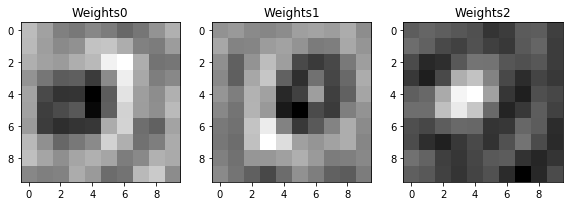

In [85]:
def get_weights(scope):
    with tf.variable_scope(scope, reuse=True):
        ww = sess.run(tf.get_variable('weights'))
        plotNNWeights(ww)
        #print(ww)
        #print(np.squeeze(ww[:,:,:,0]))
        
def plotNNWeights(units):
    print(units.shape)
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Weights' + str(i))
        ww = np.squeeze(units[:,:,:,i])
        plt.imshow(ww, interpolation="nearest", cmap="gray")

print(get_weights('encoder/conv1'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 3, 3, 3)
None


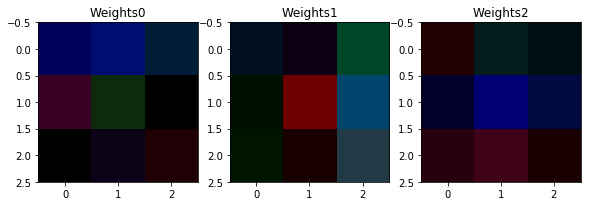

In [86]:
print(get_weights('encoder/conv2'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 3, 3, 3)
None


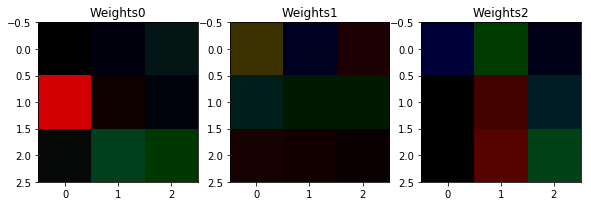

In [26]:
print(get_weights('decoder/conv1'))

(10, 10, 1, 3)
None


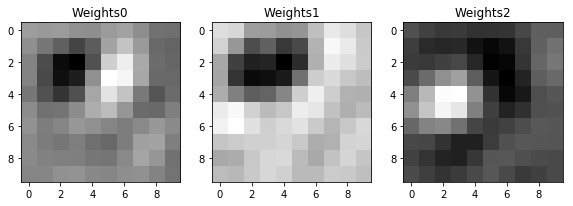

In [87]:
print(get_weights('decoder/conv2'))

## A real example: AlexNet Conv1 weights on ImageNet

The weights are useful to visualize because well-trained networks usually display nice and smooth filters without any noisy patterns. Noisy patterns can be an indicator of a network that hasn’t been trained for long enough, or possibly a very low regularization strength that may have led to overfitting.

<img src="http://cs231n.github.io/assets/cnnvis/filt1.jpeg" alt="ae" style="width: 400px;"/>

### Visualiziong activations from a layer 

In [88]:
def getActivations(scope, stimuli):
    #layer = tf.get_default_graph().get_tensor_by_name(scope + "/Relu:0")
    layer = tf.get_default_graph().get_tensor_by_name(scope + "/Maximum:0")
    units = sess.run(layer, feed_dict={X: stimuli})
    plotNNFilter(units)
            
    
def plotNNFilter(units):
    print(units.shape)
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Activation ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")


In [89]:
batch_x, _ = mnist.test.next_batch(2)

image_input = batch_x[1]
image_input = image_input.reshape([-1, 28, 28, 1])
np.shape(image_input)

(1, 28, 28, 1)

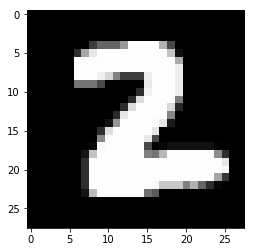

In [90]:
plt.imshow(batch_x[1].reshape([28, 28]), interpolation="nearest", cmap="gray")

In [91]:
getActivations('encoder/conv1',image_input)

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_1' with dtype float and shape [?,28,28,1]
	 [[Node: Placeholder_1 = Placeholder[dtype=DT_FLOAT, shape=[?,28,28,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_1', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-79-1b8748528fac>", line 20, in <module>
    X_noisy = tf.placeholder("float", [None, 28, 28, 1])
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1808, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4848, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/asr/tensorflow-cpu/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_1' with dtype float and shape [?,28,28,1]
	 [[Node: Placeholder_1 = Placeholder[dtype=DT_FLOAT, shape=[?,28,28,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


(1, 7, 7, 3)


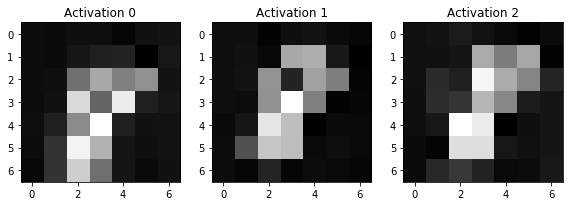

In [17]:
getActivations('encoder/conv2',image_input)

(1, 14, 14, 3)


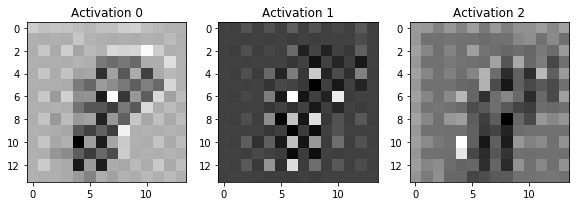

In [18]:
getActivations('decoder/conv1',image_input)

(1, 28, 28, 1)


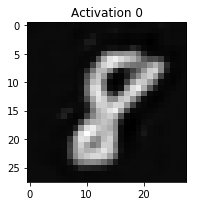

In [19]:
getActivations('decoder/conv2',image_input)

## Deep Learning and Renormalization Group (Physics)

**Deep learning** is a broad set of techniques that uses multiple layers of representation to automat- ically learn relevant features directly from structured data

**Renormalization Group** (RG) is an iterative coarse-graining scheme that allows for the extraction of relevant features (i.e. operators) as a physical system is examined at different length scales. The central goal of RG is to extract relevant features of a physical system for describing phenomena at large length scales by integrating out (i.e. marginalizing over) short distance degrees of freedom. Under this procedure, certain features, called **relevant operators**, become increasingly important while other features, dubbed **irrelevant operators**, have a diminishing effect on the physical properties of the system at large scales.

In [8]:
import string

str.strip(' Cristiano.vv')

'Cristiano.vv'

In [11]:










import numpy as np
np.ones(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])